In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter

In [13]:
def load_and_preprocess_data(file_path, train_test_split=0.8, standardization="iqr"):
    assert standardization in ["mean_std", "iqr"], "Invalid standardization method"
    assert train_test_split > 0 and train_test_split < 1, "Invalid train_test_split"
    
    df = pd.read_csv(
        file_path,
        delimiter=";",
        low_memory=False,
        decimal=",",
        usecols=lambda x: x != "Unnamed: 0",
    )

    train_split_idx = int(len(df.columns) * train_test_split)
    df_train = df.iloc[:, :train_split_idx]
    df_test = df.iloc[:, train_split_idx:]

    # Apply standardization
    if standardization == "mean_std":
        mu = df_train.values.mean()
        sigma = df_train.values.std()
        df_train = (df_train - mu) / sigma
        df_test = (df_test - mu) / sigma
        unnormalize_fn = lambda x: x * sigma + mu
    elif standardization == "iqr":
        values = pd.Series(df_train.values.flatten())
        median = values.median()
        q1 = values.quantile(0.25)
        q3 = values.quantile(0.75)
        iqr = q3 - q1
        df_train = (df_train - median) / iqr
        df_test = (df_test - median) / iqr
        unnormalize_fn = lambda x: x * iqr + median

    return df_train, df_test, unnormalize_fn

In [14]:
datafile = Path("data") / "LD2011_2014.txt"
df_train, df_test, unnormalize_fn = load_and_preprocess_data(datafile)
print(df_train.shape)
print(df_train.head())
print(df_train.tail())

(140256, 296)
     MT_001    MT_002    MT_003    MT_004    MT_005    MT_006    MT_007  \
0 -0.393819 -0.393819 -0.393819 -0.393819 -0.393819 -0.393819 -0.393819   
1 -0.393819 -0.393819 -0.393819 -0.393819 -0.393819 -0.393819 -0.393819   
2 -0.393819 -0.393819 -0.393819 -0.393819 -0.393819 -0.393819 -0.393819   
3 -0.393819 -0.393819 -0.393819 -0.393819 -0.393819 -0.393819 -0.393819   
4 -0.393819 -0.393819 -0.393819 -0.393819 -0.393819 -0.393819 -0.393819   

     MT_008    MT_009    MT_010  ...    MT_287    MT_288    MT_289    MT_290  \
0 -0.393819 -0.393819 -0.393819  ... -0.029346 -0.212724 -0.393819  1.020342   
1 -0.393819 -0.393819 -0.393819  ... -0.024971 -0.207317 -0.393819  1.082446   
2 -0.393819 -0.393819 -0.393819  ... -0.042470 -0.201855 -0.393819  1.004854   
3 -0.393819 -0.393819 -0.393819  ... -0.024971 -0.185633 -0.393819  1.035829   
4 -0.393819 -0.393819 -0.393819  ... -0.038095 -0.201855 -0.393819  0.989367   

     MT_291    MT_292    MT_293    MT_294    MT_295   

In [17]:
def visualize_energy_consumption(
    df, client_indices, smoothing_window, fig=None, label_fn=None
):
    # Visualize the smoothed energy consumption of selected clients from the training set
    dates = pd.date_range(start="2011-01-01", periods=len(df), freq="15min")
    if fig is None:
        fig = plt.figure(figsize=(12, 8))
    for i in client_indices:
        if isinstance(df, pd.DataFrame):
            smoothed_data = df.iloc[:, i].rolling(window=smoothing_window).mean()
        else:
            smoothed_data = df.rolling(window=smoothing_window).mean()
        label = label_fn(i) if label_fn else f"Client {i+1}"
        plt.plot(dates, smoothed_data, label=label)
    plt.legend()
    smoothing_hours = smoothing_window / 4
    plt.title(
        f"Energy Consumption of {len(client_indices)} Clients\n(Smoothed over {smoothing_hours} hours)"
    )
    plt.xlabel("Time")
    plt.gca().xaxis.set_major_locator(YearLocator())
    plt.gca().xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.ylabel("Energy Consumption (kWh)")
    return fig

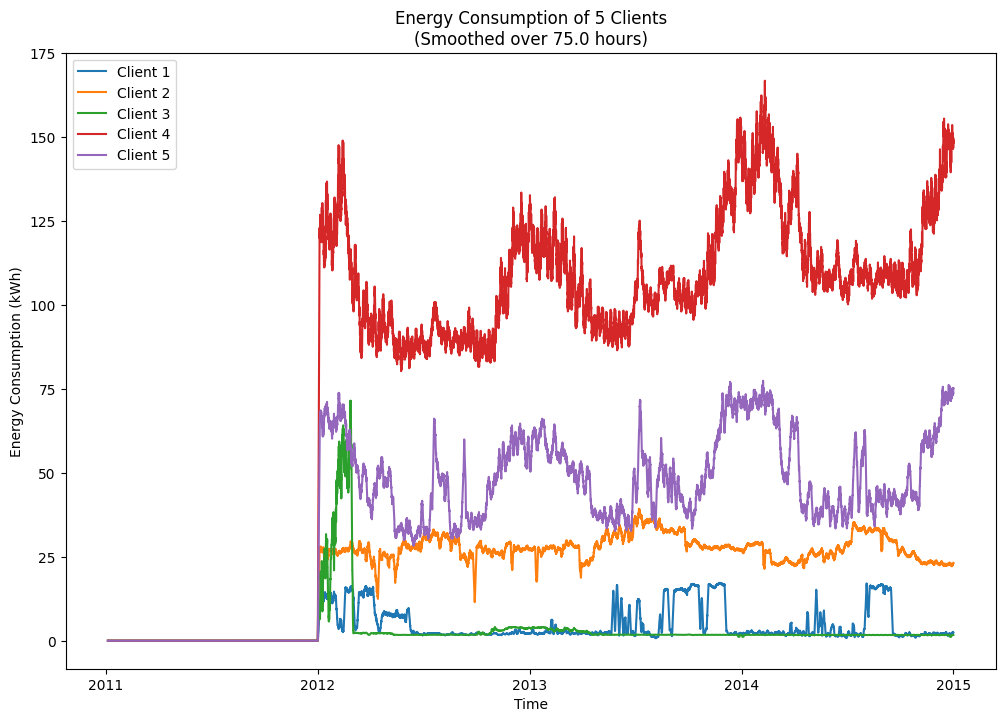

In [18]:
visualize_energy_consumption(unnormalize_fn(df_train), [x for x in range(5)], 300);

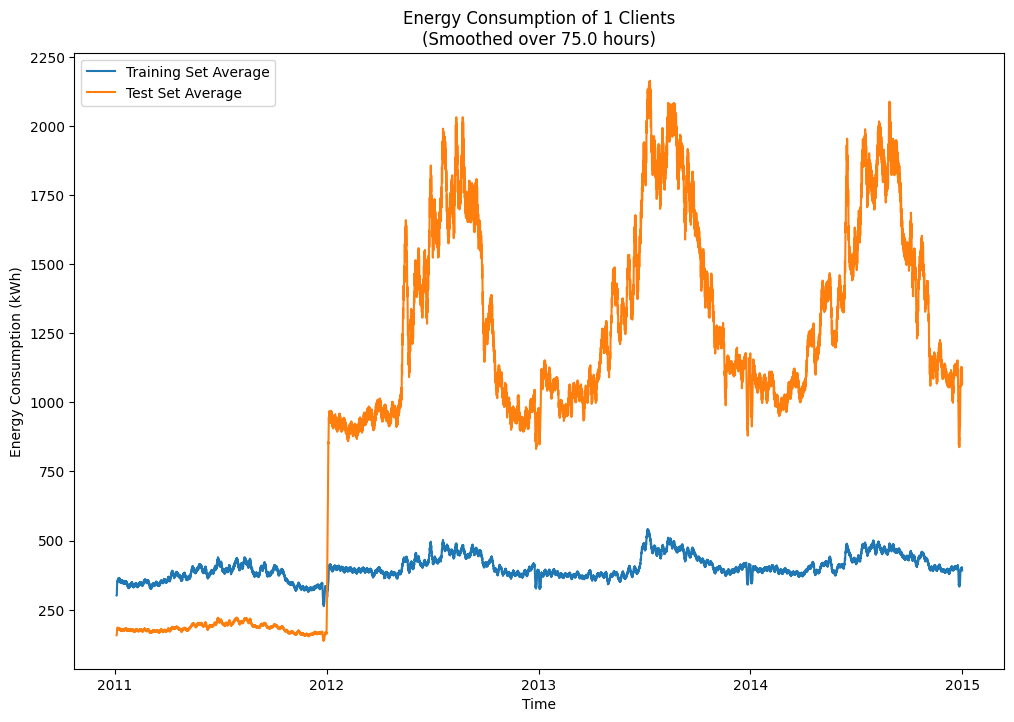

In [19]:
# Get average energy consumption over time for training set
df_train_avg = df_train.mean(axis=1)
fig = visualize_energy_consumption(
    unnormalize_fn(df_train_avg), [0], 300, label_fn=lambda x: f"Training Set Average"
)

# Get average energy consumption over time for test set
df_test_avg = df_test.mean(axis=1)
fig = visualize_energy_consumption(
    unnormalize_fn(df_test_avg), [0], 300, fig=fig, label_fn=lambda x: f"Test Set Average"
)

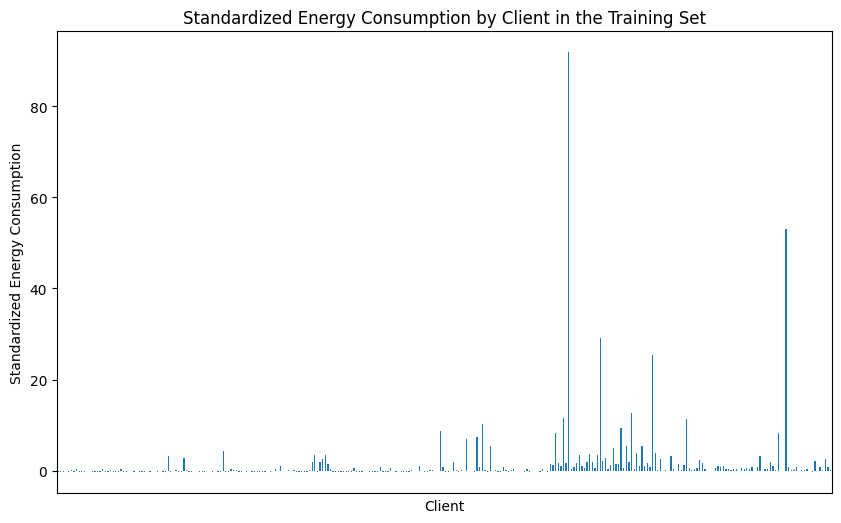

Text(0.5, 0, 'Client')

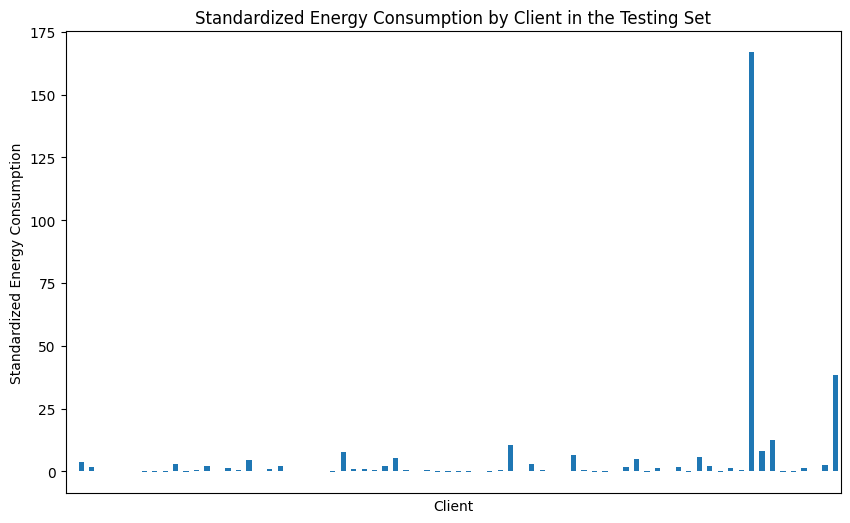

In [21]:
# Show standardised energy consumption by client for the training set
df_train.mean().plot(kind='bar', figsize=(10, 6))
plt.xticks([])
plt.title("Standardized Energy Consumption by Client in the Training Set")
plt.ylabel("Standardized Energy Consumption")
plt.xlabel("Client")
plt.show()

# Show standardised energy consumption by client for the testing set
df_test.mean().plot(kind='bar', figsize=(10, 6))
plt.xticks([])
plt.title("Standardized Energy Consumption by Client in the Testing Set")
plt.ylabel("Standardized Energy Consumption")
plt.xlabel("Client")
